**1 Project Scope**

In this project the 'Structural Protein Sequences' dataset from kaggle will be used to predict molecular structure type of different structures based on features such as crystallisation method and experimental technique. This will involve an exploratory data analysis procedure on the datasets to gain useful insights about the different classifications. Various feature engineering techniques will be used to find which features are best to use in the models, involving techniques such as principal component analysis (PCA). After this multiple supervised machine learning models will be built to facilitate predictions involving simple models such as KNN and more complex models such as neural networks. Multiple evaluation techniques will then be used to evaluate each model and decide on which model should be used for future predictions.

**2 Packages**

**2.1 Preprocessing packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer

**2.2 Feature engineering packages**

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
#from category_encoders import MEstimateEncoder

**2.3 Model packages**

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

**2.4 Neural network packages**

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score

**2.5 Evaluation packages**

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap
from sklearn.metrics import confusion_matrix 

**3 Load in datasets and inspect**

In [6]:
seq = pd.read_csv('pdb_data_seq.csv')
seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [7]:
NoDups = pd.read_csv('pdb_data_no_dups.csv')
NoDups.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


Merge dataframes based on their 'structureid'

**3.1 Merge datasets on the 'structureId' column**

In [8]:
df = NoDups.merge(seq, how='inner', on='structureId').drop_duplicates(['structureId']).reset_index()
df.head()

,index,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
2,4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
3,5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG,24,DNA
4,7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein


In [9]:
df.isnull().sum() # Checking to see the number of NaN values in each column

index                           0
structureId                     0
classification                  2
experimentalTechnique           0
macromoleculeType_x          3064
residueCount_x                  0
resolution                  12504
structureMolecularWeight        0
crystallizationMethod       44531
crystallizationTempK        43738
densityMatthews             16298
densityPercentSol           16272
pdbxDetails                 22341
phValue                     35728
publicationYear             23518
chainId                         0
sequence                       28
residueCount_y                  0
macromoleculeType_y          3064
dtype: int64

**3.2 Dropping NaN values - Imputation was not used due to the large number of NaN values**

In [10]:
df = df.dropna() # Drop NaN values
len(df)

65748

**3.3 Dropping duplicate columns**

In [11]:
df.columns

Index(['index', 'structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType_x', 'residueCount_x', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'residueCount_y', 'macromoleculeType_y'],
      dtype='object')

In [12]:
columns_to_drop = ['residueCount_y', 'macromoleculeType_y', 'index']
df = df.drop(labels=columns_to_drop, axis=1)
df.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType_x', 'residueCount_x', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [13]:
df.macromoleculeType_x.value_counts()

Protein                       60757
Protein#DNA                    2554
Protein#RNA                    1050
DNA                             598
RNA                             544
Protein#DNA#RNA                 137
Protein#DNA#DNA/RNA Hybrid       31
DNA/RNA Hybrid                   30
RNA#DNA/RNA Hybrid               17
DNA#RNA                          14
Protein#DNA/RNA Hybrid           11
Protein#RNA#DNA/RNA Hybrid        4
DNA#DNA/RNA Hybrid                1
Name: macromoleculeType_x, dtype: int64

**4 Exploratory Data Analysis**

**4.1 Data Types**

In [14]:
df.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType_x          object
residueCount_x                int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

Columns cardinality

In [15]:
for column in list(df.columns):
    if df[column].dtype == 'object':
        print(f'{column} : {df[column].nunique()}')

structureId : 65748
classification : 2503
experimentalTechnique : 9
macromoleculeType_x : 13
crystallizationMethod : 405
pdbxDetails : 51981
chainId : 37
sequence : 35674


**4.2 Aggregate Statistics**

Dataset describe

In [16]:
df.describe()

,residueCount_x,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
count,65748.000000,65748.000000,6.574800e+04,65748.000000,65748.000000,65748.000000,65748.000000,65748.000000
mean,808.848376,2.154840,1.001163e+05,291.116304,2.676959,51.587572,6.787697,2010.306671
std,1617.575226,0.583059,2.844500e+05,9.122386,0.705623,9.970807,1.289879,5.017304
min,5.000000,0.480000,4.885400e+02,4.000000,0.000000,0.000000,0.000000,1985.000000
25%,279.000000,1.790000,3.232959e+04,290.000000,2.220000,44.540000,6.000000,2007.000000
50%,463.000000,2.060000,5.326010e+04,293.000000,2.500000,50.650000,7.000000,2011.000000
75%,852.000000,2.500000,9.786094e+04,295.000000,2.920000,57.910000,7.500000,2015.000000
max,89160.000000,9.500000,1.249011e+07,398.000000,12.700000,90.330000,100.000000,2018.000000


Mean pH by macromolecular type - pH seems to be quite constant over all classifications (might be good visualise the distribution of this)

In [17]:
df.groupby(['macromoleculeType_x']).phValue.mean() 

macromoleculeType_x
DNA                           6.670050
DNA#DNA/RNA Hybrid            7.000000
DNA#RNA                       6.564286
DNA/RNA Hybrid                6.410000
Protein                       6.795557
Protein#DNA                   6.696116
Protein#DNA#DNA/RNA Hybrid    7.019355
Protein#DNA#RNA               6.726277
Protein#DNA/RNA Hybrid        6.518182
Protein#RNA                   6.732629
Protein#RNA#DNA/RNA Hybrid    7.150000
RNA                           6.630331
RNA#DNA/RNA Hybrid            6.029412
Name: phValue, dtype: float64

Mean pH by classification - pH seems to be quite constant over all classifications (a lot of classification classes so may be better to only use the top classes as some don't have many values)

In [18]:
df.groupby(['classification']).phValue.mean() 

classification
'STRUCTURAL PROTEIN/DNA                  6.000000
3-METHYLADENINE DNA GLYCOSYLASE I/DNA    7.500000
ACETYLCHOLINE-BINDING PROTEIN            6.375000
ACTIN BINDING, STRUCTURAL PROTEIN        7.400000
ACTIN-BINDING PROTEIN                    7.100000
                                           ...   
viral protein/RNA                        7.700000
viral protein/immune system              6.888889
viral protein/membrane protein           6.150000
viral protein/signaling protein          7.500000
viral protein/transcription inhibitor    7.500000
Name: phValue, Length: 2503, dtype: float64

Mean resolution by classification - resolution values vary over different classifications (again may be useful to visualise)

In [19]:
df.groupby(['classification']).resolution.mean() 

classification
'STRUCTURAL PROTEIN/DNA                  3.150000
3-METHYLADENINE DNA GLYCOSYLASE I/DNA    1.850000
ACETYLCHOLINE-BINDING PROTEIN            2.311250
ACTIN BINDING, STRUCTURAL PROTEIN        2.300000
ACTIN-BINDING PROTEIN                    2.107500
                                           ...   
viral protein/RNA                        2.395000
viral protein/immune system              2.908889
viral protein/membrane protein           4.030000
viral protein/signaling protein          3.200000
viral protein/transcription inhibitor    2.208000
Name: resolution, Length: 2503, dtype: float64

Mean molecular weight by classification - Molecular weights vary greatly over different structures as would be expected

In [20]:
df.groupby(['classification']).structureMolecularWeight.mean() 

classification
'STRUCTURAL PROTEIN/DNA                  202393.080000
3-METHYLADENINE DNA GLYCOSYLASE I/DNA     28538.490000
ACETYLCHOLINE-BINDING PROTEIN            272038.641250
ACTIN BINDING, STRUCTURAL PROTEIN         35381.990000
ACTIN-BINDING PROTEIN                     69492.037500
                                             ...      
viral protein/RNA                        144795.190000
viral protein/immune system              189268.442222
viral protein/membrane protein            66816.620000
viral protein/signaling protein           70846.880000
viral protein/transcription inhibitor     84288.822000
Name: structureMolecularWeight, Length: 2503, dtype: float64

Mean crystallisation temperature by classification - crystallisation temperatures don't seem to vary much between different structures

In [21]:
df.groupby(['classification']).crystallizationTempK.mean() 

classification
'STRUCTURAL PROTEIN/DNA                  293.000000
3-METHYLADENINE DNA GLYCOSYLASE I/DNA    294.000000
ACETYLCHOLINE-BINDING PROTEIN            291.000000
ACTIN BINDING, STRUCTURAL PROTEIN        293.000000
ACTIN-BINDING PROTEIN                    291.250000
                                            ...    
viral protein/RNA                        295.000000
viral protein/immune system              291.222222
viral protein/membrane protein           293.000000
viral protein/signaling protein          289.000000
viral protein/transcription inhibitor    293.000000
Name: crystallizationTempK, Length: 2503, dtype: float64

**4.3 Getting top classifications**

The classification data needs to be cut short before any other EDA continues as the cardinality of the classification column is too large - limit it to the top ten classifications

In [22]:
counter = Counter(df.classification)
num_classes = 10
sorted_classifications = counter.most_common()[:num_classes]
top_classifications = [c[0] for c in sorted_classifications]

top_df = df[[c in top_classifications for c in df.classification]]

top_df.head()

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
465,1A72,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,374,2.60,40658.50,"VAPOR DIFFUSION, HANGING DROP",277.0,2.30,46.82,CRYSTALS GROWN FROM 4 MICROLITER HANGING DROPS...,8.40,1998.0,A,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...
1103,1AR4,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,402,1.90,45428.53,microseeding,277.0,2.05,32.00,PROTEIN WAS CRYSTALLIZED AT 50MG/ML FROM 2.15 ...,6.10,1996.0,A,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...
1104,1AR5,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,402,1.60,45430.34,microseeding,277.0,2.04,32.20,PROTEIN WAS CRYSTALLIZED FROM 2.15 M (NH4)2SO4...,6.15,1996.0,A,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...
1207,1AUE,TRANSFERASE,X-RAY DIFFRACTION,Protein,200,2.33,24203.73,"VAPOR DIFFUSION, HANGING DROP",277.0,2.25,45.00,"HANGING DROPS AT 4 C, pH 8.0, vapor diffusion ...",8.00,1997.0,A,ELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMER...
1211,1AUK,HYDROLASE,X-RAY DIFFRACTION,Protein,489,2.10,52423.45,"VAPOR DIFFUSION, HANGING DROP",291.0,3.30,63.00,PROTEIN WAS CRYSTALLIZED BY VAPOR DIFFUSION IN...,5.40,1998.0,A,RPPNIVLIFADDLGYGDLGCYGHPSSTTPNLDQLAAGGLRFTDFYV...


Check if it was done correctly

In [23]:
top_df.classification.value_counts() 

HYDROLASE                        10223
TRANSFERASE                       7678
OXIDOREDUCTASE                    6176
IMMUNE SYSTEM                     2435
LYASE                             2332
TRANSCRIPTION                     1735
TRANSPORT PROTEIN                 1683
HYDROLASE/HYDROLASE INHIBITOR     1678
SIGNALING PROTEIN                 1307
ISOMERASE                         1283
Name: classification, dtype: int64

**4.4 Visualisation of data**

Side by side boxplots of pH by classification - distribution of pH is very similar for all classifications

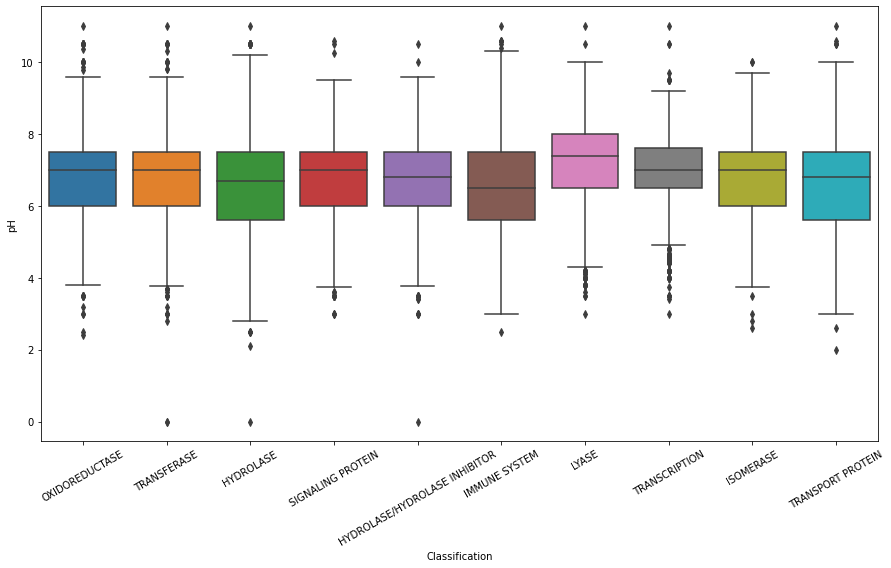

In [24]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df, x='classification', y='phValue')
plt.ylabel('pH')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()

Side by side boxplots of resolution by classification - distribution of resolution is very similar for all classifications and there are a lot of outliers for all classifications

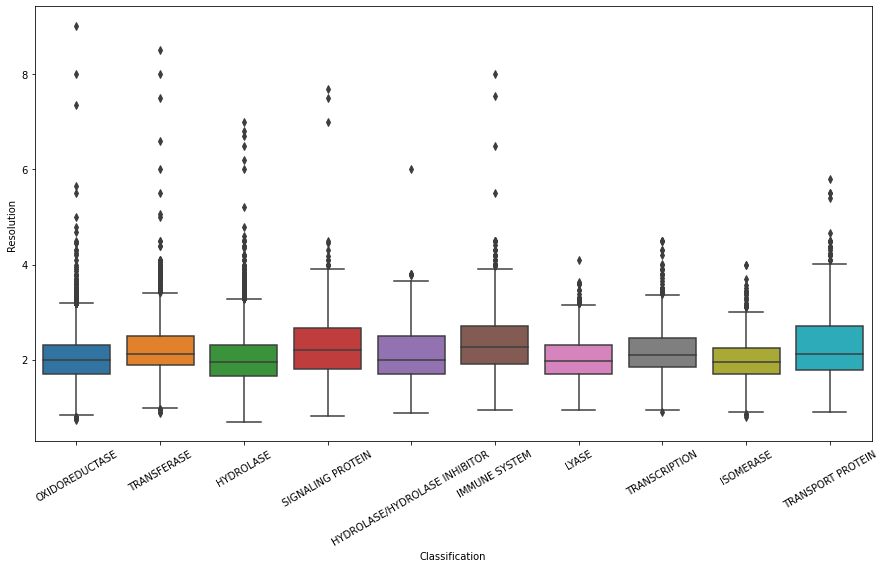

In [25]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df, x='classification', y='resolution')
plt.ylabel('Resolution')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()

Side by side boxplots of molecular weight by classification - distribution of molecular weight is very similar for all classifications and there are a lot of outliers for all classifications

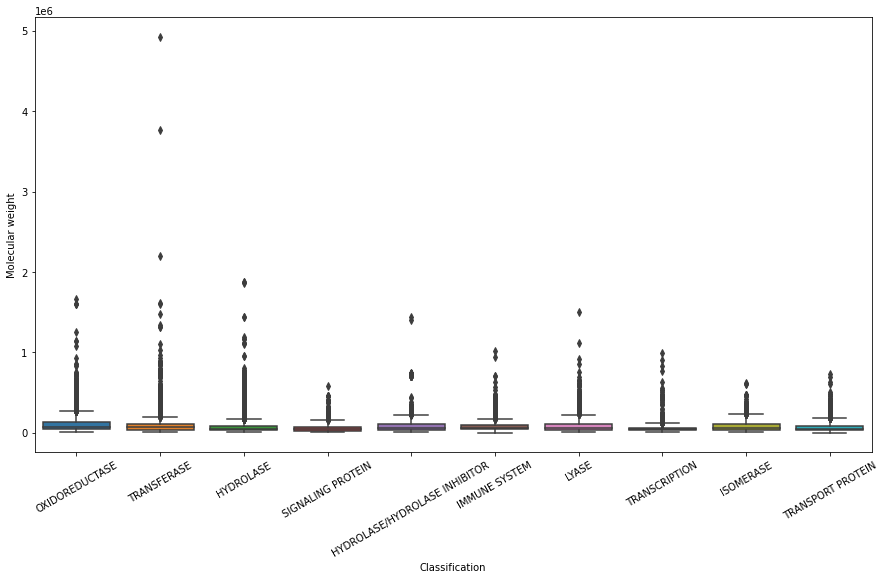

In [26]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df, x='classification', y='structureMolecularWeight')
plt.ylabel('Molecular weight')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()

Side by side boxplots of crystallisation temperature by classification - distribution of classification temperature is very similar for all classifications. Crytallisation temperatures less than 273 K do not make sense as that is absolute 0. Therefore, these values will be discarded

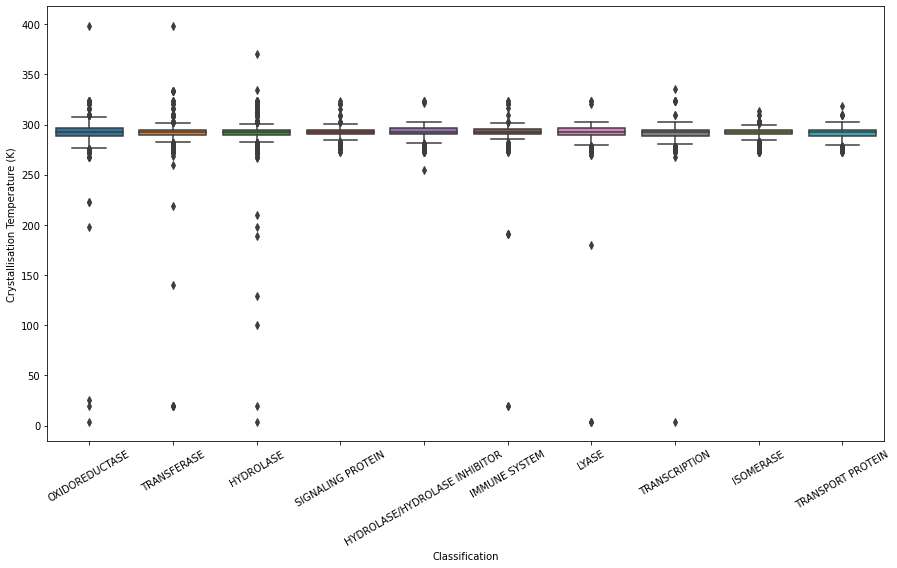

In [27]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df, x='classification', y='crystallizationTempK')
plt.ylabel('Crystallisation Temperature (K)')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()

In [28]:
top_df_new = top_df[top_df.crystallizationTempK > 273] # Getting crystallisation temperatures greater than 273 K

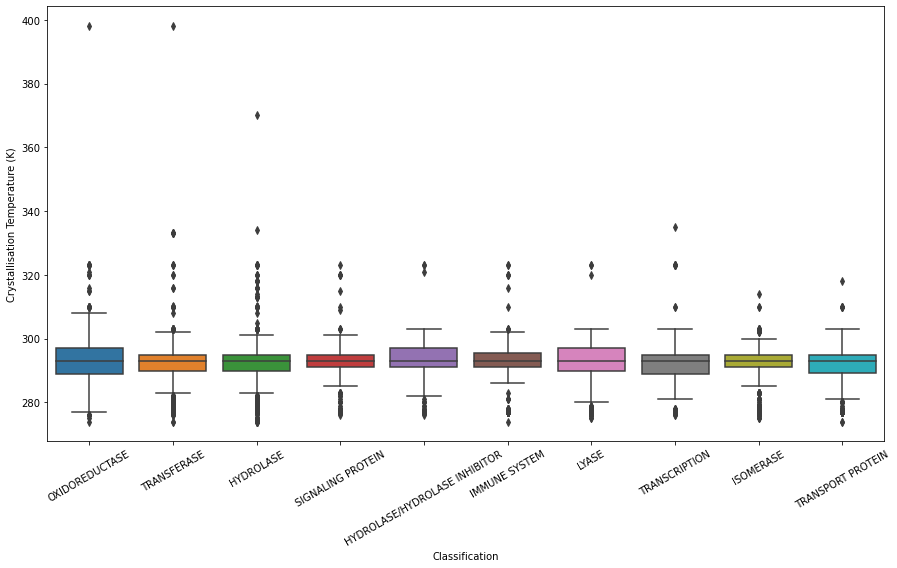

This graph looks better without the outliers


In [29]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df_new, x='classification', y='crystallizationTempK')
plt.ylabel('Crystallisation Temperature (K)')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()
print('This graph looks better without the outliers')

Side by side boxplot of residue count by classification - Very similar distributions but large outliers

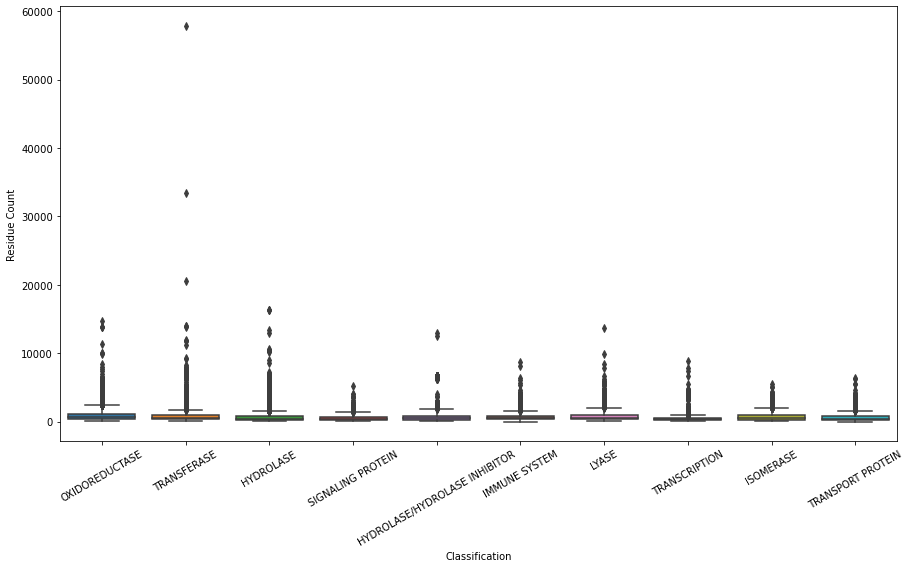

In [30]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.boxplot(data=top_df_new, x='classification', y='residueCount_x')
plt.ylabel('Residue Count')
plt.xlabel('Classification')
plt.xticks(rotation=30)
plt.show()

**5 Preprocessing**

**5.1 Count vectorizer to transform sequence into a matrix of token count**

In [31]:
top_df_new['sequence']= top_df_new['sequence'].astype(str).apply(lambda x : ' '.join(x)) # change to str so they're iterable and then join them with a space

new_df = top_df_new.drop(['chainId','structureId'], axis=1) # Dropping ID columns

counter = CountVectorizer(token_pattern=r"(?u)\b\w+\b") # Count vectorizer object

tst = counter.fit_transform(top_df_new['sequence']) # Creating token counts matrix

In [32]:
seq_chars = pd.DataFrame(tst.todense(),columns=counter.get_feature_names(),index=new_df.index) # Transform tst into a matrix of token counts

In [33]:
new_df[seq_chars.columns] = seq_chars

new_df = new_df.drop(['sequence'], axis=1) # drop sequence column as its been tokenized

new_df.columns

Index(['classification', 'experimentalTechnique', 'macromoleculeType_x',
       'residueCount_x', 'resolution', 'structureMolecularWeight',
       'crystallizationMethod', 'crystallizationTempK', 'densityMatthews',
       'densityPercentSol', 'pdbxDetails', 'phValue', 'publicationYear', 'a',
       'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

**5.2 Check cardinality of columns**

In [34]:
for column in list(new_df.columns):
    if new_df[column].dtype == 'object':
        print(f'{column} : {new_df[column].nunique()}')

classification : 10
experimentalTechnique : 9
macromoleculeType_x : 6
crystallizationMethod : 251
pdbxDetails : 28637


In [35]:
new_df = new_df.drop(['crystallizationMethod', 'pdbxDetails'], axis=1) # Drop these columns as they have a high cardinality which is too great for one hot encoding

**5.3 Separate labels and features**

In [36]:
feature_names = ['experimentalTechnique', 'macromoleculeType_x',
       'residueCount_x', 'resolution', 'structureMolecularWeight',
        'crystallizationTempK', 'densityMatthews',
       'densityPercentSol', 'phValue', 'publicationYear', 'a',
       'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

features = new_df[feature_names]

labels = new_df.classification

**5.4 Label Encoder for labels**

In [37]:
label_encoder = LabelEncoder()

labels_encoded = label_encoder.fit_transform(labels)

labels_encoded

array([5, 5, 5, ..., 0, 0, 0])

**5.5 One hot encoding for categorical columns**

In [38]:
features_encoded = pd.get_dummies(features)
features_encoded

,residueCount_x,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,a,b,...,"experimentalTechnique_SOLUTION SCATTERING, X-RAY DIFFRACTION",experimentalTechnique_X-RAY DIFFRACTION,"experimentalTechnique_X-RAY DIFFRACTION, EPR","experimentalTechnique_X-RAY DIFFRACTION, NEUTRON DIFFRACTION",macromoleculeType_x_Protein,macromoleculeType_x_Protein#DNA,macromoleculeType_x_Protein#DNA#DNA/RNA Hybrid,macromoleculeType_x_Protein#DNA#RNA,macromoleculeType_x_Protein#RNA,macromoleculeType_x_RNA
465,374,2.60,40658.50,277.0,2.30,46.82,8.40,1998.0,29,0,...,0,1,0,0,1,0,0,0,0,0
1103,402,1.90,45428.53,277.0,2.05,32.00,6.10,1996.0,25,0,...,0,1,0,0,1,0,0,0,0,0
1104,402,1.60,45430.34,277.0,2.04,32.20,6.15,1996.0,25,0,...,0,1,0,0,1,0,0,0,0,0
1207,200,2.33,24203.73,277.0,2.25,45.00,8.00,1997.0,6,0,...,0,1,0,0,1,0,0,0,0,0
1211,489,2.10,52423.45,291.0,3.30,63.00,5.40,1998.0,49,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139867,786,2.26,90248.22,298.0,3.10,60.30,8.50,2017.0,28,0,...,0,1,0,0,1,0,0,0,0,0
139888,1136,4.20,133183.53,293.0,4.58,73.12,8.00,2018.0,8,0,...,0,1,0,0,1,0,0,0,0,0
139889,117,1.95,13480.91,298.0,2.91,57.70,8.50,2018.0,4,0,...,0,1,0,0,1,0,0,0,0,0
139890,1134,4.50,134096.44,298.0,3.00,58.94,8.00,2018.0,8,0,...,0,1,0,0,1,0,0,0,0,0


**6 Feature Engineering**

**6.1 Mutual Information**

In [39]:
def mutual_info_calculator(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = mutual_info_calculator(features_encoded, labels_encoded)

mi_scores

residueCount_x                                                  0.433343
structureMolecularWeight                                        0.286739
g                                                               0.182415
l                                                               0.181996
e                                                               0.165936
i                                                               0.164629
a                                                               0.156610
v                                                               0.154368
r                                                               0.141708
d                                                               0.140170
f                                                               0.138759
p                                                               0.134125
t                                                               0.130439
m                                                  

Text(0.5, 1.0, 'Mutual Information Scores')

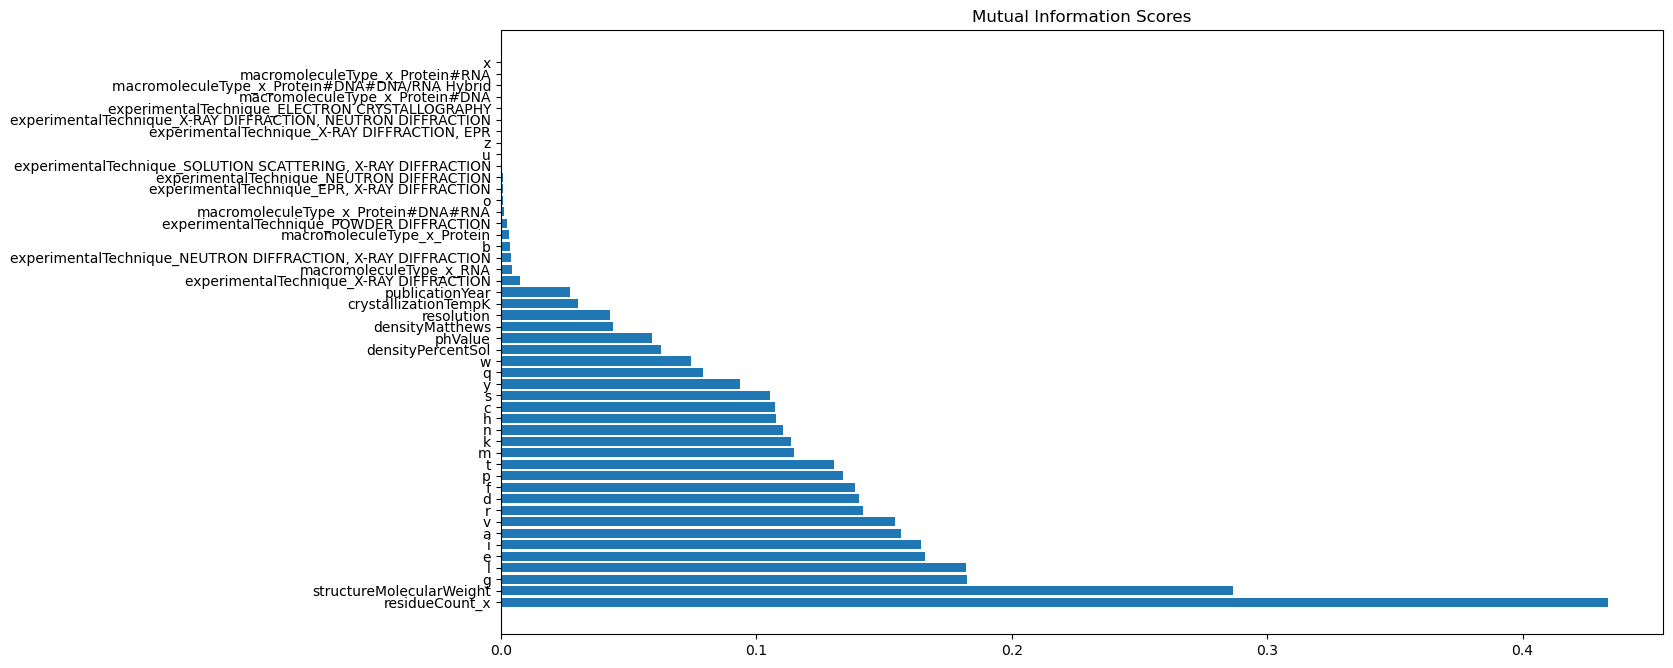

In [40]:
plt.figure(dpi=100, figsize=(15, 8))
width = np.arange(len(mi_scores)) # Returns evenly spaced values within length of the mutual information scores array
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title('Mutual Information Scores')

In [41]:
width

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

There are a lot of values with 0 mutual information scores between them and the classification. This indicates that there is no correlation at all between them, hinting that they could be removed from the dataset prior to predictions. However, they may be useful when combined with other features so further work should be done to see if they are useful in combination with other features. It was seen that the feature with the highest mutual information score was residueCount, meaning that this variable was the best correlation with the classification.

**6.2 KMeans Clustering**

Finding optimum number of clusters based on inertia - there's seems to be a bit of an elbow around 3-5 clusters, it was there decided that 4 clusters would be used for the cluster labels

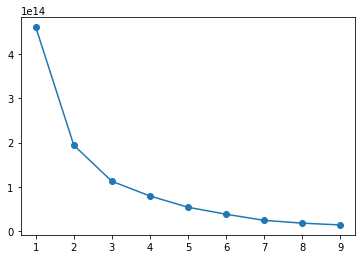

In [42]:
inertias = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(features_encoded)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,10), inertias, '-o')
plt.show()

In [43]:
kmeans_optimum = KMeans(n_clusters=4)
features_encoded['Cluster'] = kmeans_optimum.fit_predict(features_encoded)
features_encoded['Cluster'] = features_encoded['Cluster'].astype('category')

Plot of pH against molecular weight showing the clustering - This plot shows definite separation by cluster

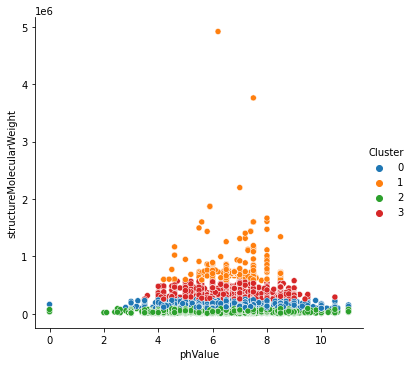

In [44]:
sns.relplot(data=features_encoded, x='phValue', y='structureMolecularWeight', hue='Cluster')
plt.show()

In [45]:
features_encoded.Cluster.value_counts()

2    26027
0     8638
3     1283
1      428
Name: Cluster, dtype: int64

Cluster labels were added to break up complicated relationships between multiple features. This was done using 4 clusters, from which it can be seen that most data points were classified as cluster 0.

**6.3 Principal Component Analysis**

Split data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels_encoded, train_size=0.8, test_size=0.2, random_state=2)

Standardize data

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Creat PCA features

In [48]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca, columns=component_names)
X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)

X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
0,1.647454,-0.357537,0.063698,0.020543,0.027951,0.176096,-0.686512,0.124814,-0.624937,0.204134,...,-0.156119,-0.114080,-0.176989,0.501769,-0.175189,-0.002562,-0.008090,1.137401e-14,-6.700404e-16,-1.875707e-15
1,0.194297,0.403589,-0.145567,0.041458,-0.012214,0.031719,-0.379561,2.307696,0.455775,-1.230473,...,0.214853,0.407390,-0.143936,-0.349572,-0.168131,0.003292,0.005738,1.363470e-14,1.371187e-15,7.521145e-16
2,-4.177558,-0.941840,0.252295,0.004827,0.056540,-0.022500,0.441774,1.015160,-1.275342,0.682868,...,0.077059,0.068395,0.030118,-0.326250,0.103894,0.002725,-0.004798,2.301723e-14,9.152675e-16,-4.764905e-16
3,-0.099790,-1.159710,0.101811,-0.000353,0.067853,-0.182418,0.697536,1.349017,-0.989755,0.688014,...,-0.398833,0.467044,-0.053891,-0.162641,0.105088,0.002546,-0.005027,-3.339903e-15,-1.641301e-15,-2.734538e-16
4,-0.104805,-0.512388,0.013592,-0.043287,0.044391,-0.208494,0.434890,0.179472,1.624957,0.347631,...,-0.565235,-0.148308,-0.392337,-0.372812,0.012641,-0.002329,0.005990,-9.283941e-15,4.938240e-16,2.711255e-15


In [49]:
X_train_pca.shape

(29100, 49)

In [50]:
X_test_pca.shape

(7276, 49)

Graph explained variance of each feature and apply elbow rule to see which features could be omitted

Text(0.5, 1.0, 'Graph of variance explained by each PCA component')

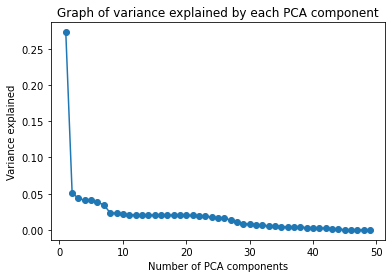

In [51]:
variances = pca.explained_variance_ratio_
x_axis = list(range(1, len(component_names)+1))

plt.plot(x_axis, variances, '-o')
plt.xlabel('Number of PCA components')
plt.ylabel('Variance explained')
plt.title('Graph of variance explained by each PCA component')

In [52]:
X_train_pca_reduced = X_train_pca.iloc[:,0:35]

X_test_pca_reduced = X_test_pca.iloc[:,0:35]

X_train_pca_reduced

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1.647454,-0.357537,0.063698,0.020543,0.027951,0.176096,-0.686512,0.124814,-0.624937,0.204134,...,-0.144611,0.425584,0.114592,0.324254,0.407089,0.148537,-0.226276,0.176295,0.418919,0.063639
1,0.194297,0.403589,-0.145567,0.041458,-0.012214,0.031719,-0.379561,2.307696,0.455775,-1.230473,...,0.248576,-0.350850,0.925152,-0.054843,-1.064239,-0.230392,1.059093,0.898999,-0.088105,0.252744
2,-4.177558,-0.941840,0.252295,0.004827,0.056540,-0.022500,0.441774,1.015160,-1.275342,0.682868,...,-0.202150,-0.174272,0.413136,0.978633,-0.209008,0.098827,0.660722,0.695204,-0.440706,0.277243
3,-0.099790,-1.159710,0.101811,-0.000353,0.067853,-0.182418,0.697536,1.349017,-0.989755,0.688014,...,0.802354,-0.927052,0.311468,-0.137676,-0.490313,-0.680500,-0.411299,-0.404737,-0.163825,-0.469374
4,-0.104805,-0.512388,0.013592,-0.043287,0.044391,-0.208494,0.434890,0.179472,1.624957,0.347631,...,0.512179,-0.143508,0.492929,-0.059546,0.616223,-0.631222,-0.592731,-1.093445,-1.181857,-0.219778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29095,0.620154,-0.951802,0.204287,-0.016104,0.073828,0.047840,-0.138456,-0.972994,0.125682,1.075910,...,0.066486,0.130818,-0.734694,-0.989248,-0.854180,-0.786147,-0.245784,0.725871,-0.000065,0.736339
29096,12.464293,-0.097434,-0.184948,-0.054176,-0.081444,0.028221,1.842969,0.202767,-0.054428,0.930804,...,-2.302778,-1.552362,-0.462640,1.709812,-0.609430,-0.543956,-0.301987,-1.170426,-0.304576,0.016830
29097,-2.225377,-0.570606,-0.010078,-0.001384,0.108912,0.053912,-0.532333,0.115868,-0.218415,-0.355803,...,0.075976,-0.049578,-0.290386,-0.184704,0.234989,-0.394303,-0.050778,-0.506663,0.131601,-0.165533
29098,-1.559941,-1.429144,0.219593,-0.068443,0.106291,-0.202865,0.281570,-0.239141,0.710925,1.495792,...,-0.068458,-0.470724,0.371694,-0.316174,0.510165,-0.250263,-0.287932,-0.771882,-0.625355,-0.116705


97.5% of the variance of the data is explained by the first 35 PCA components, meaning the following 14 components only explain 2.5% of the variance. Therefore, only the first 35 components will be used to build the models.

**7 Simple Supervised ML Models** 

These models will be build using the original data with the clusters labels and then with the PCA data.

The models that will be built are:

- K Nearest Neighbour
- Decision Tree
- Random Forest
- XGBoost


Sets of data for model:

- Original (w/ cluster labels) = X_train, X_test, y_train, y_test -> not scaled
- PCA = X_train_pca_reduced, X_test_pca_reduced, y_train, y_test

**7.1 Standardizer Object to be used in pipelines**

In [53]:
numerical_transformer = StandardScaler()

**7.2 K Nearest Neighbour**

**7.2.1 With original data (w/ cluster labels)**

In [54]:
scores = []
for neighbors in range(1, 20):
    KNN = KNeighborsClassifier(n_neighbors=neighbors)
    KNN_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer), 
    ('model', KNN)])
    KNN_pipeline.fit(X_train, y_train)
    scores.append(KNN_pipeline.score(X_test, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the number of neighbours was changed')

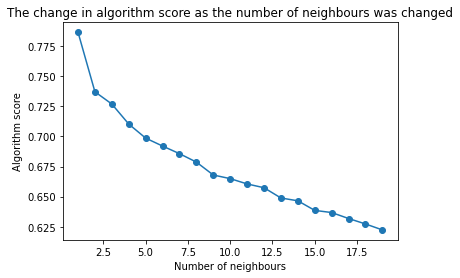

In [55]:
plt.plot(list(range(1, 20)), scores, '-o')
plt.xlabel('Number of neighbours')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of neighbours was changed')

Accuracy decreases as the number of neighbours in the algorithm increases. It seems like 1 Neighbour is the optimum, so this will be used in the final KNN model

In [56]:
KNN = KNeighborsClassifier(n_neighbors=1)

KNN_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer), 
    ('model', KNN)
])

KNN_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=1))])

In [57]:
KNN_pipeline.score(X_test, y_test)

0.7865585486531061

**7.2.1.1 Evaluation of KNN model**

Classification Report - This shows good precision, recall and f1-score (close to the previously found score for the model)

In [246]:
predictions_KNN = KNN_pipeline.predict(X_test)
print(classification_report(y_test, predictions_KNN))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      2023
           1       0.65      0.72      0.68       336
           2       0.85      0.80      0.83       492
           3       0.70      0.70      0.70       247
           4       0.76      0.77      0.77       435
           5       0.84      0.85      0.84      1284
           6       0.54      0.57      0.55       244
           7       0.74      0.70      0.72       336
           8       0.80      0.82      0.81      1547
           9       0.78      0.73      0.75       332

    accuracy                           0.79      7276
   macro avg       0.75      0.75      0.75      7276
weighted avg       0.79      0.79      0.79      7276



Cross-validation (Only done for the better KNN model) - The cross validation shows that the model was not as accurate as previously thoought, giving an average accuracy just over 55%. However, this is still a good accuracy based on there being 10 classes to classify.

In [241]:
# Cross validation
cross_val_scores = cross_val_score(KNN_pipeline, features_encoded, labels_encoded, cv=5, scoring='accuracy')

# Print and average results
print(cross_val_scores)
print("Baseline: %.2f%% (%.2f%%)" % (cross_val_scores.mean()*100, cross_val_scores.std()*100))

[0.54714129 0.60054983 0.58474227 0.53924399 0.48659794]
Baseline: 55.17% (3.97%)


Confusion Matrix (Only done for better KNN model) - The confusion matrix shows a good visualisation of how accurate the KNN model is with the original data. It shows that that the model correctly classifies most data.

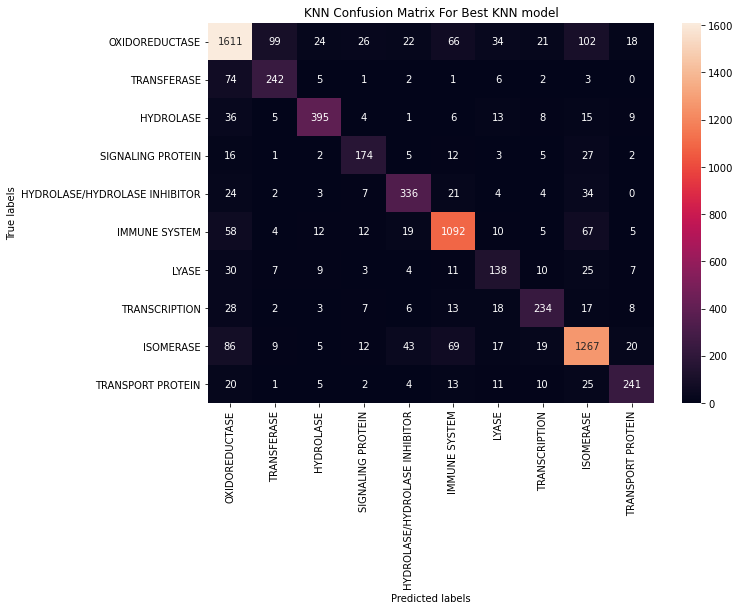

In [247]:
KNN_cm = confusion_matrix(y_test, predictions_KNN)

labels = KNN_pipeline.classes_

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(KNN_cm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('KNN Confusion Matrix For Best KNN model')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**Permutation Importance** was not used to evaluate the algorithm due to the computational requirements, however below shows the code that would be necessary for it:

In [ ]:
perm = PermutationImportance(KNN_pipeline, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

**SHAP** again was not implemeented due to computational requirements, but below is the code that would be needed.

In [ ]:
explainer = KernelExplainer(KNN_pipeline) # Explainer for KNN model
shap_values = explainer.shap_values(X_test, approximate=True) # Get SHAP values for the predictions in the test data
shap.summary_plot(shap_values, X_test, plot_type='bar') # Summary plot of how much each feature contributes to the predictions

**7.2.2 With PCA data**

In [148]:
scores = []
for neighbors in range(1, 20):
    KNN = KNeighborsClassifier(n_neighbors=neighbors)
    KNN.fit(X_train_pca_reduced, y_train)
    scores.append(KNN.score(X_test_pca_reduced, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the number of neighbours was changed (with PCA data)')

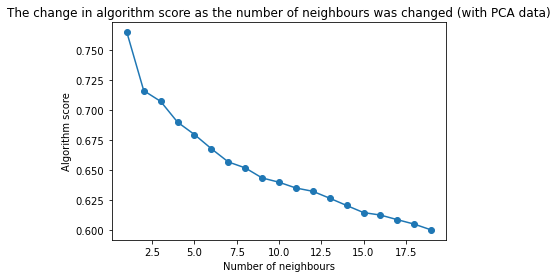

In [150]:
plt.plot(list(range(1, 20)), scores, '-o')
plt.xlabel('Number of neighbours')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of neighbours was changed (with PCA data)')

Accuracy decreases as the number of neighbours increased. Therefore, the number of neighbours used in the final KNN pca model will be 1

In [151]:
KNN_pca = KNeighborsClassifier(n_neighbors=1)

KNN_pca.fit(X_train_pca_reduced, y_train)

KNN_pca.score(X_test_pca_reduced, y_test)

0.7647058823529411

**7.2.2.1 Evaluation of KNN_pca model**

Classification Report - This shows good precision, recall and f1-scores but not as high as the other KNN model

In [156]:
predictions_pca = KNN_pca.predict(X_test_pca_reduced)
print(classification_report(y_test, predictions_pca))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2023
           1       0.63      0.70      0.66       336
           2       0.84      0.79      0.81       492
           3       0.65      0.67      0.66       247
           4       0.76      0.74      0.75       435
           5       0.81      0.81      0.81      1284
           6       0.51      0.50      0.51       244
           7       0.74      0.67      0.70       336
           8       0.77      0.80      0.78      1547
           9       0.73      0.70      0.71       332

    accuracy                           0.76      7276
   macro avg       0.72      0.72      0.72      7276
weighted avg       0.77      0.76      0.76      7276



**7.2.3 K Nearest Neighbour Summary**

K nearest neighbours models were made both with the original data and the PCA data. These models were then evaluated from which it was found that the original data model (KNN_pipeline) was a better model than PCA data model (KNN_pca). This was shown through KNN_pipeline having a greater accuracy, precision, recall and f1-score. Furthermore, code for permutation importance and SHAP was included but not run due to the computational requirements of this. 

**7.3 Decision Tree**

**7.3.1 With original data (w/ cluster labels)**

Decision Tree Scaler

In [58]:
numerical_transformer_DT = StandardScaler()

In [59]:
depths = list(range(5, 50, 5))
DT_scores = []

for depth in depths:
    DT = DecisionTreeClassifier(max_depth=depth)

    DT_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer_DT), 
    ('model', DT)
])

    DT_pipeline.fit(X_train, y_train)

    DT_scores.append(DT_pipeline.score(X_test, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the depth was changed (Original Data)')

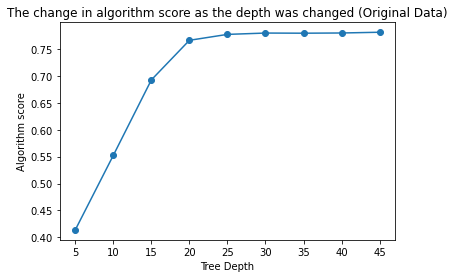

In [60]:
plt.plot(depths, DT_scores, '-o')
plt.xlabel('Tree Depth')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the depth was changed (Original Data)')

It was seen that the score levels out at around a depth of 25. Therefore, a depth of 25 should be used to reduce computational requirements

In [61]:
DT = DecisionTreeClassifier(max_depth=25)

DT_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer_DT), 
    ('model', DT)
])

DT_pipeline.fit(X_train, y_train)

DT_pipeline.score(X_test, y_test)

0.7807861462341946

**7.3.1.1 Evaluation of DT model**

Classification report - This model shows good precision, recall and f-1 scores, with these values being very comparable to the KNN_pipeline model

In [248]:
predictions_DT = DT_pipeline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      2023
           1       0.81      0.62      0.71       336
           2       0.91      0.82      0.86       492
           3       0.95      0.53      0.68       247
           4       0.92      0.60      0.73       435
           5       0.79      0.80      0.79      1284
           6       0.71      0.40      0.51       244
           7       0.79      0.63      0.70       336
           8       0.69      0.80      0.74      1547
           9       0.86      0.59      0.70       332

    accuracy                           0.75      7276
   macro avg       0.81      0.66      0.72      7276
weighted avg       0.77      0.75      0.75      7276



Cross-validation (Only done for the better DT model) - It was found, using cross validation, that the accuracy was a lot less than previously thought, with accuracy being a bit over 50%. However, based on there being 10 classification this can still be seen as quite accurate, even when accounting for the standard deviation of the accuracy

In [245]:
# Cross validation
cross_val_scores_DT = cross_val_score(DT_pipeline, features_encoded, labels_encoded, cv=5, scoring='accuracy')

# Print average results
print(cross_val_scores)
print("Baseline: %.2f%% (%.2f%%)" % (cross_val_scores_DT.mean()*100, cross_val_scores_DT.std()*100))

[0.54714129 0.60054983 0.58474227 0.53924399 0.48659794]
Baseline: 51.99% (4.93%)


Confusion matrix (only done for best DT model) - It can be seen that the colour along the diagonal is the lightest, whereas everywhere else is dark. This shows that the predictions for this model are quite accurate.

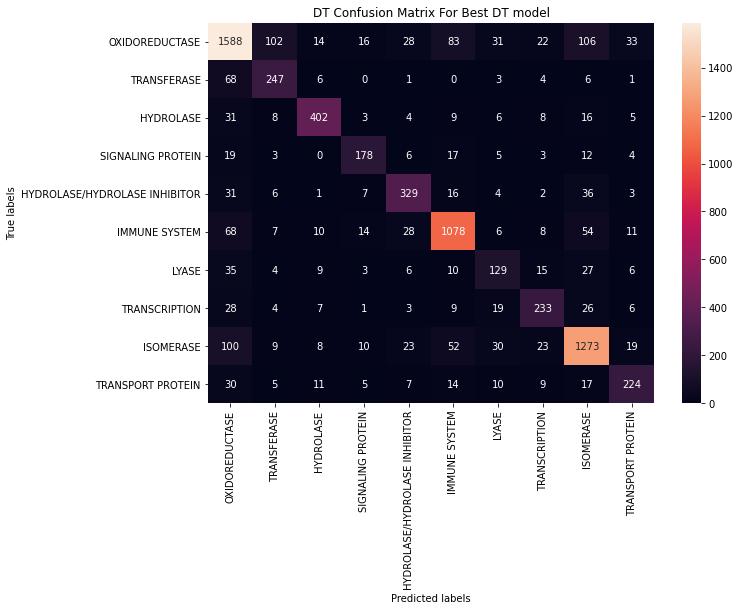

In [249]:
DT_cm = confusion_matrix(y_test, predictions_DT)

labels = DT_pipeline.classes_

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(DT_cm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('DT Confusion Matrix For Best DT model')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**7.3.2 With PCA data**

In [194]:
depths = list(range(5, 50, 5))
DT_pca_scores = []

for depth in depths:
    DT = DecisionTreeClassifier(max_depth=depth)
    
    DT.fit(X_train_pca_reduced, y_train)

    DT_pca_scores.append(DT.score(X_test_pca_reduced, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the depth was changed (Original Data)')

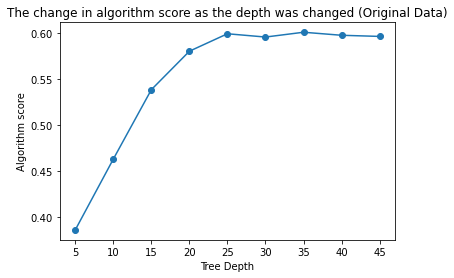

In [197]:
plt.plot(depths, DT_pca_scores, '-o')
plt.xlabel('Tree Depth')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the depth was changed (Original Data)')

The algorithm score sees to level out at around a depth of 25. Therefore, a max depth of 25 will be used for the pca model.

In [198]:
DT_pca = DecisionTreeClassifier(max_depth=25)

DT_pca.fit(X_train_pca_reduced, y_train)

DT_pca.score(X_test_pca_reduced, y_test)

0.5949697636063771

**7.3.2.1 Evaluation of DT model with PCA data**

In [199]:
predictions = DT_pca.predict(X_test_pca_reduced)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      2023
           1       0.52      0.55      0.54       336
           2       0.69      0.68      0.69       492
           3       0.47      0.45      0.46       247
           4       0.50      0.54      0.52       435
           5       0.62      0.60      0.61      1284
           6       0.35      0.32      0.33       244
           7       0.55      0.53      0.54       336
           8       0.62      0.62      0.62      1547
           9       0.49      0.50      0.50       332

    accuracy                           0.59      7276
   macro avg       0.55      0.54      0.54      7276
weighted avg       0.59      0.59      0.59      7276



**7.3.3 Decision Tree Summary**

Decision tree models were made with both the original data (DT_pipeline) and the PCA data (DT_pca), with both models being optimised to find the optimal depth for the models (optimum depth for both was 25). These models were then evaluated to find which was the more accurate. It was found that the DT_pipeline model was much more accurate than the DT_pca model, in terms of accuracy, precision, recall and f1-score values. 

**7.4 Random Forest**

Random Forest Scaler

In [200]:
numerical_transformer_RF = StandardScaler()

**7.4.1 With original data (w/ cluster labels)**

In [202]:
num_trees = list(range(50, 400, 50))

RF_scores = []

for trees in num_trees:
    RF = RandomForestClassifier(n_estimators=trees)

    RF_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer_RF), 
    ('model', RF)
])

    RF_pipeline.fit(X_train, y_train)

    RF_scores.append(RF_pipeline.score(X_test, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the number of trees was changed (Original Data)')

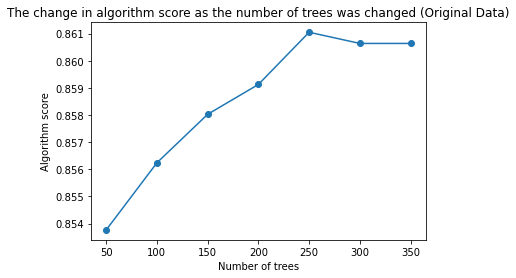

In [204]:
plt.plot(num_trees, RF_scores, '-o')
plt.xlabel('Number of trees')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of trees was changed (Original Data)')

It was found that changing the number of trees did not massively change the score of the model. However, the highest score was foun when 250 trees were used, so this will be used for the final model.

In [205]:
RF = RandomForestClassifier(n_estimators=250)

RF_pipeline = Pipeline(steps = [
    ('scaler', numerical_transformer_RF), 
    ('model', RF)
])

RF_pipeline.fit(X_train, y_train)

RF_pipeline.score(X_test, y_test)

0.8581638262781748

**7.4.1.1 Evaluation of Random Forest model**

Classification report - this shows that the model exhibits very good accuracy based on its precision, recall and f1-score values. With this model being the best model so far

In [255]:
predictions_RF = RF_pipeline.predict(X_test)
print(classification_report(y_test, predictions_RF))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2023
           1       0.81      0.71      0.76       336
           2       0.95      0.88      0.91       492
           3       1.00      0.76      0.86       247
           4       0.98      0.80      0.88       435
           5       0.92      0.91      0.92      1284
           6       0.89      0.57      0.70       244
           7       0.84      0.75      0.79       336
           8       0.84      0.90      0.87      1547
           9       0.98      0.72      0.83       332

    accuracy                           0.86      7276
   macro avg       0.90      0.79      0.84      7276
weighted avg       0.87      0.86      0.86      7276



Cross validation scoring (only done for best RF model) - From cross validation scoring it was found that the model performed significantly worse than originally thought. However, this model still performed the best in cross validation out of all the models so far. It also exhibited a low STD, further showing the accuracy of the model

In [254]:
# Cross validation
cross_val_score_RF = cross_val_score(RF_pipeline, features_encoded, labels_encoded, cv=5, scoring='accuracy')

# Print averages
print(cross_val_score_RF)
print("Baseline: %.2f%% (%.2f%%)" % (cross_val_score_RF.mean()*100, cross_val_score_RF.std()*100))

[0.65929082 0.68742268 0.69278351 0.65869416 0.58364261]
Baseline: 65.64% (3.90%)


Confusion matrix (only done for best RF model) - This shows that the model performed very well, due to the light colours being on the diagonal, as was previously shown in the cross validation

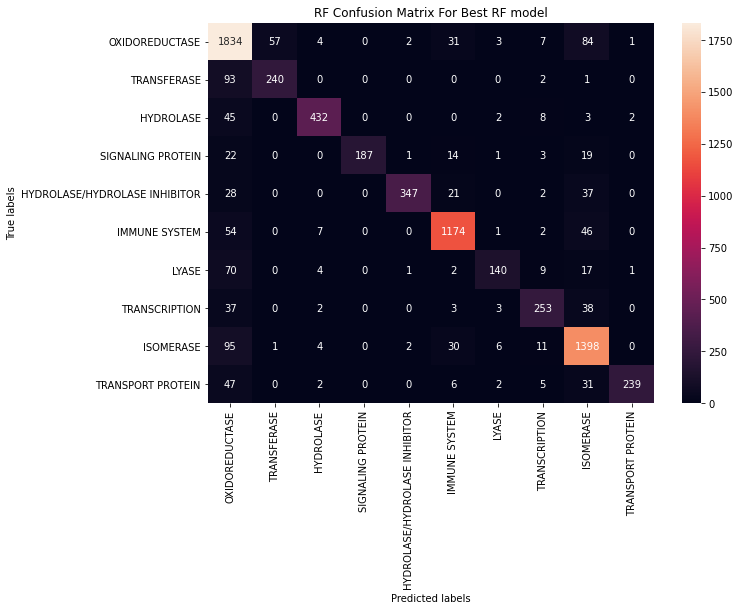

In [258]:
RF_cm = confusion_matrix(y_test, predictions_RF)

labels = RF_pipeline.classes_

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(RF_cm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('RF Confusion Matrix For Best RF model')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**7.4.2 With PCA data**

In [209]:
num_trees = list(range(50, 400, 50))

RF_pca_scores = []

for trees in num_trees:
    RF_pca = RandomForestClassifier(n_estimators=trees)
    
    RF_pca.fit(X_train_pca_reduced, y_train)

    RF_pca_scores.append(RF_pca.score(X_test_pca_reduced, y_test))

Text(0.5, 1.0, 'The change in algorithm score as the number of trees was changed (PCA Data)')

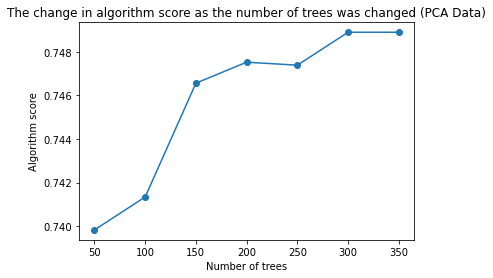

In [211]:
plt.plot(num_trees, RF_pca_scores, '-o')
plt.xlabel('Number of trees')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of trees was changed (PCA Data)')

It was found that increasing the number of trees did not greatly affect the accuracy of the models. However, the maximum accuracy was found to occur when 300 trees were used. Therefore, 300 will be used for the final model

In [212]:
RF_pca = RandomForestClassifier(n_estimators=300)
    
RF_pca.fit(X_train_pca_reduced, y_train)

RF_pca.score(X_test_pca_reduced, y_test)

0.750549752611325

**7.4.2.1 Evaluation of Random Forest model with PCA data**

Classification report - It was found that this model displayed good precision, recall and f1-score values but was not as good as the random forest model with the original data

In [214]:
predictions = RF_pca.predict(X_test_pca_reduced)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      2023
           1       0.87      0.60      0.71       336
           2       0.94      0.79      0.86       492
           3       0.98      0.50      0.66       247
           4       0.98      0.59      0.73       435
           5       0.83      0.77      0.80      1284
           6       0.87      0.34      0.49       244
           7       0.86      0.61      0.72       336
           8       0.69      0.83      0.75      1547
           9       0.98      0.52      0.68       332

    accuracy                           0.75      7276
   macro avg       0.86      0.64      0.72      7276
weighted avg       0.78      0.75      0.75      7276



**7.4.3 Random Forest Summary**

Random forest models were made with the original data (RF_pipeline) and with the PCA data (RF_pca). Both models were then optimised to find the optimum number of trees (RF_pipeline = 250 and RF_pca = 300). These models were then evaluated to see which model would be better for future predictions. It was found that the model with the original data was much better than the PCA data model. This indicates that the decision trees don't respond well to the PCA data in this project, as both the Decision Tree and Random Forest models decreased in accuracy when the PCA data was used.

**7.5 XGBoost**

XGBoost Scaler

In [222]:
numerical_transformer_XGB = StandardScaler()

**7.5.1 With original data (w/ cluster labels)**

In [220]:
num_trees = list(range(50, 400, 50))

XGB_scores = []

for trees in num_trees:
    XGB = XGBClassifier(n_estimators=trees)

    XGB_pipeline = Pipeline(steps=[
    ('scaler', numerical_transformer_XGB), 
    ('model', XGB)
])
    XGB_pipeline.fit(X_train, y_train)

    XGB_scores.append(XGB_pipeline.score(X_test, y_test))

[14:32:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:06] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Text(0.5, 1.0, 'The change in algorithm score as the number of trees was changed (Original Data)')

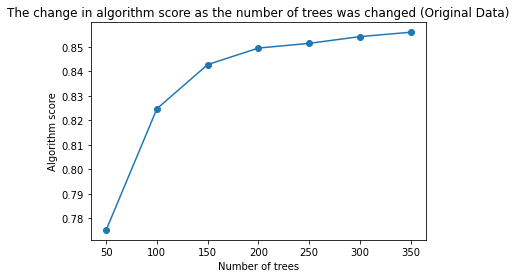

In [221]:
plt.plot(num_trees, XGB_scores, '-o')
plt.xlabel('Number of trees')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of trees was changed (Original Data)')

The algorithm score increased as the number of trees were increased. It was found that the best model was built when 350 trees were used. Therefore, 350 will be used for the final XGB model.

In [223]:
XGB = XGBClassifier(n_estimators=350)

XGB_pipeline = Pipeline(steps=[
    ('scaler', numerical_transformer_XGB), 
    ('model', XGB)
])

XGB_pipeline.fit(X_train, y_train)

XGB_pipeline.score(X_test, y_test)

[14:39:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8559648158328752

**7.5.1.1 Evaluation of XGBoost model**

Classification report - This gave very good precision, recall and f1-score values, which were very comparable to the best decision tree model

In [259]:
predictions_XGB = XGB_pipeline.predict(X_test)
print(classification_report(y_test, predictions_XGB))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2023
           1       0.83      0.72      0.77       336
           2       0.95      0.89      0.92       492
           3       0.96      0.77      0.85       247
           4       0.95      0.79      0.86       435
           5       0.90      0.91      0.90      1284
           6       0.79      0.59      0.67       244
           7       0.83      0.76      0.79       336
           8       0.83      0.89      0.86      1547
           9       0.95      0.75      0.84       332

    accuracy                           0.86      7276
   macro avg       0.88      0.80      0.83      7276
weighted avg       0.86      0.86      0.85      7276



Cross validation (Only done for the best XGB model) - This once again showed a significant decrease in the apparent performance of the model than previously thought, meaning predictions were not as accurate as thought. However, the accuracy was still seen to be better than the KNN and DT model but not quite as good as the RF model.

In [257]:
# Cross validation 
cross_val_scores_XGB = cross_val_score(XGB_pipeline, features_encoded, labels_encoded, cv=5, scoring='accuracy')

# Print average results
print(cross_val_scores_XGB)
print("Baseline: %.2f%% (%.2f%%)" % (cross_val_scores_XGB.mean()*100, cross_val_scores_XGB.std()*100))

[17:29:24] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:44] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:23] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Confusion matrix (Only done for the best XGB model) - This showed that the predictions from the model were quite accurate, shown through the light colours on the diagonal. However, predictions were not quite as accurate as the RF model.

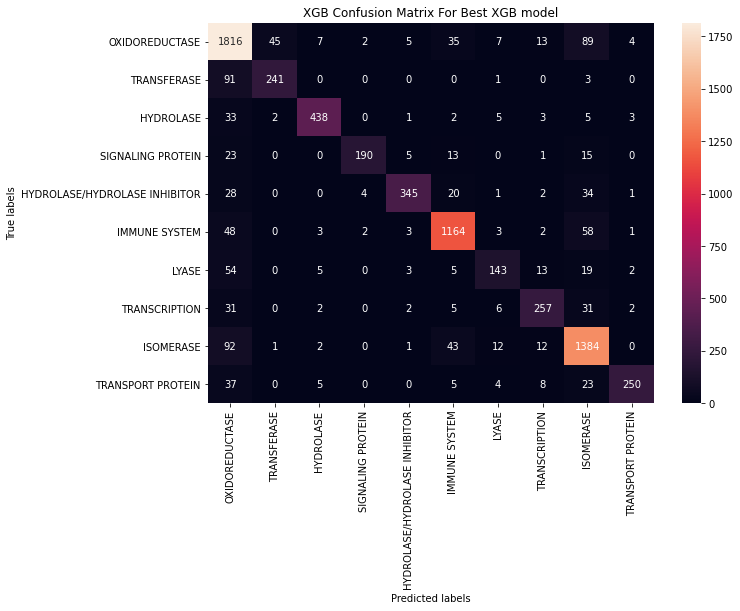

In [260]:
XGB_cm = confusion_matrix(y_test, predictions_XGB)

labels = XGB_pipeline.classes_

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(XGB_cm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGB Confusion Matrix For Best XGB model')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**7.5.2 With PCA data**

In [225]:
num_trees = list(range(50, 400, 50))

XGB_pca_scores = []

for trees in num_trees:
    XGB_pca = XGBClassifier(n_estimators=trees)

    XGB_pca.fit(X_train_pca_reduced, y_train)

    XGB_pca_scores.append(XGB_pca.score(X_test_pca_reduced, y_test))

[14:50:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:43] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Text(0.5, 1.0, 'The change in algorithm score as the number of trees was changed (PCA Data)')

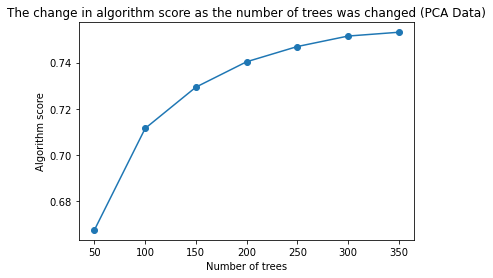

In [226]:
plt.plot(num_trees, XGB_pca_scores, '-o')
plt.xlabel('Number of trees')
plt.ylabel('Algorithm score')
plt.title('The change in algorithm score as the number of trees was changed (PCA Data)')

The accuracy of the model can be seen to increase as the number of trees increases, with the highest accuracy occuring when 350 trees were used. Therefore, 350 trees will be used for the final model

In [228]:
XGB_pca = XGBClassifier(n_estimators=350)

XGB_pca.fit(X_train_pca_reduced, y_train)

XGB_pca.score(X_test_pca_reduced, y_test)

[15:03:13] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7531610775151182

**7.5.2.1 Evaluation of XGB model with PCA data**

Classification report - precision, recall and f1-score values were seen to be good, but not as good as the XGB model with the orginal data

In [229]:
predictions = XGB_pca.predict(X_test_pca_reduced)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      2023
           1       0.81      0.62      0.71       336
           2       0.91      0.82      0.86       492
           3       0.95      0.53      0.68       247
           4       0.92      0.60      0.73       435
           5       0.79      0.80      0.79      1284
           6       0.71      0.40      0.51       244
           7       0.79      0.63      0.70       336
           8       0.69      0.80      0.74      1547
           9       0.86      0.59      0.70       332

    accuracy                           0.75      7276
   macro avg       0.81      0.66      0.72      7276
weighted avg       0.77      0.75      0.75      7276



**7.5.3 XGB Summary**

XGB models were made with the original data (XGB_pipeline) and with the PCA data (XGB_pca). These models were also optimised to find the optimum number of trees for both models (350 trees for both models). These models were then evaluated to find which was best for future predictions, from which it was found that the model using the original data was more accurate, show through its higher accuracy, precision, recall and f1-score values. This further shows that tree models do not as accurately model the PCA data as the original data.

**7.6 Summary of the Simple Supervised ML Models**

In this section 4 different models were built to predict the classification of the model based on the original data and PCA data, with each model being optimised based using parameters such as the number of neighbours for KNN. For each model it was found that a more accurate model results when the original data was used rather than the PCA data. 

The models were then evaluated using metrics such as accuracy, classification report, cross validation and a confusion matrix. For all of the models the apparent accuracy decreased significantly when cross validation was carried out, but all models were still seen as accurate due to the presence of 10 classifications. From all these metrics it was found that the random forest model was the most accurate, with a cross validation accuracy average of 65.64%. Furthermore, the least accurate model was found to be the decision tree model, with a cross validation accuracy average of 51.99%, but this was still seen as accurate based on the number of classes. 

In conclusion, it was decided that if a simple model were to be used for the prediction of the molecules structure that the random forest model should be used due to its high cross validation score compared to the other models.

**8 Deep Neural Network Model**

Data for models:

- X_train, X_test, y_train_OH, y_test_OH
- X_train_pca_reduced, X_test_pca_reduced, y_train_OH, y_test_OH

**8.1 With Original Data**

**8.1.1 Converting labels to one hot encoding vectors**

In [141]:
y_train_OH = tf.keras.utils.to_categorical(y_train, dtype='int64')

y_test_OH = tf.keras.utils.to_categorical(y_test, dtype='int64')

**8.1.2 Model Architecture Function for Random Search**

In [274]:
def build_model(num_neurons_1, num_neurons_2):

    deep_model = Sequential()

    deep_model.add(layers.InputLayer(input_shape=(X_train.shape[1],))) # Input shape is (number of features, 1) so model expected a number for each features for each row

    deep_model.add(layers.Dense(num_neurons_1, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(num_neurons_2, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(10, activation='softmax'))

    deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return deep_model

**8.1.3 Randomized Grid Search Function for Hyperparameter Tuning (batch size, epochs and number of neurons)**

In [277]:
def randomized_search(data):
    
    # Parameter grid for batch size, epochs, optimizers and number of neurons
    param_grid = {'batch_size': sp_randint(10, 100), 'nb_epoch': sp_randint(10, 200), 'num_neurons_1': sp_randint(1, 64), 'num_neurons_2': sp_randint(1,64)} # Parameter grid
    
    model = KerasClassifier(build_fn=build_model) # Model in Keras wrapper
    
    # Randomized Grid Search with model, parameter grid, 10 iterations, accuracy scorer and n_jobs = -1 (using all processesor)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring=make_scorer(accuracy_score))
    
    grid_results = grid.fit(data, y_train_OH, verbose=1) # Fitting data to model
    
    print(grid_results) # Printing out best results
    
    print(f'Best {grid_results.best_score_} using {grid_results.best_params_}')
    

In [278]:
grid_standardizer = StandardScaler()
    
X_train_grid_scaled = grid_standardizer.fit_transform(X_train) # Standarize training data for grid search

**8.1.3.1 Randomized Grid Search for Original Data**

In [279]:
randomized_search(X_train_grid_scaled)

432/432 [==============================] - 0s 593us/step - loss: 1.9910 - accuracy: 0.3007


747/747 [==============================] - 0s 575us/step - loss: 1.9661 - accuracy: 0.2936
RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A1B42EF220>,
                   n_iter=20,
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A30C3490>,
                                        'nb_epoch': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1B69B6CA0>,
                                        'num_neurons_1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1AC94A6D0>,
                                        'num_neurons_2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1BF056AF0>},
                   scoring=make_scorer(accuracy_score))
Best nan using {'batch_size': 39, 'nb_epoch': 162, 'num_neurons_1': 53, 'num_neurons_2': 4}


**8.1.4 Standardizer Object**

In [155]:
numerical_transformer_deep = StandardScaler()

**8.1.5 Deep Learning Pipeline**

**8.1.5.1 Final Model with Optimized Neurons**

In [280]:
def build_model_final():
    
    deep_model = Sequential()

    deep_model.add(layers.InputLayer(input_shape=(X_train.shape[1],))) # Input shape is (number of features, 1) so model expected a number for each features for each row

    deep_model.add(layers.Dense(53, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(4, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(10, activation='softmax'))

    deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return deep_model

**8.1.5.2 Pipeline**

In [281]:
deep_pipeline = Pipeline(steps=[
    ('scaler', numerical_transformer_deep),
    ('model', build_model_final())
])

stopper = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Early Stopping object to stop when loss levels out at a minimum

**8.1.6 History Object for later callbacks**

In [282]:
history = History() # history object to put into the algorithm so that the metrics of the training can be remembered and later plotted

**8.1.7 Fitting Model**

In [283]:
# Batch size = number of samples through the network before hyperparameters are tuned.

# Validation split for hyperparameter tuning was set at 20% of training data

deep_pipeline.fit(X_train, y_train_OH, model__epochs=162, model__batch_size=39, model__verbose=1, model__callbacks=[stopper, history], model__validation_split=0.2)

Epoch 1/162
597/597 [==============================] - 0s 822us/step - loss: 2.0214 - accuracy: 0.2915 - val_loss: 1.8196 - val_accuracy: 0.3428
Epoch 2/162
597/597 [==============================] - 0s 733us/step - loss: 1.8036 - accuracy: 0.3651 - val_loss: 1.6783 - val_accuracy: 0.4232
Epoch 3/162
597/597 [==============================] - 0s 698us/step - loss: 1.7083 - accuracy: 0.3982 - val_loss: 1.6132 - val_accuracy: 0.4352
Epoch 4/162
597/597 [==============================] - 0s 692us/step - loss: 1.6627 - accuracy: 0.4085 - val_loss: 1.5785 - val_accuracy: 0.4421
Epoch 5/162
597/597 [==============================] - 0s 702us/step - loss: 1.6396 - accuracy: 0.4120 - val_loss: 1.5596 - val_accuracy: 0.4474
Epoch 6/162
597/597 [==============================] - 0s 717us/step - loss: 1.6255 - accuracy: 0.4166 - val_loss: 1.5425 - val_accuracy: 0.4488
Epoch 7/162
597/597 [==============================] - 0s 695us/step - loss: 1.6091 - accuracy: 0.4226 - val_loss: 1.5296 - val_ac

597/597 [==============================] - 0s 700us/step - loss: 1.4517 - accuracy: 0.4777 - val_loss: 1.3819 - val_accuracy: 0.5108
Epoch 58/162
597/597 [==============================] - 0s 691us/step - loss: 1.4517 - accuracy: 0.4800 - val_loss: 1.3810 - val_accuracy: 0.5069
Epoch 59/162
597/597 [==============================] - 0s 672us/step - loss: 1.4533 - accuracy: 0.4760 - val_loss: 1.3909 - val_accuracy: 0.5034
Epoch 60/162
597/597 [==============================] - 0s 699us/step - loss: 1.4497 - accuracy: 0.4782 - val_loss: 1.3849 - val_accuracy: 0.5115
Epoch 61/162
597/597 [==============================] - 0s 662us/step - loss: 1.4456 - accuracy: 0.4802 - val_loss: 1.3829 - val_accuracy: 0.5127
Epoch 62/162
597/597 [==============================] - 0s 703us/step - loss: 1.4477 - accuracy: 0.4789 - val_loss: 1.3735 - val_accuracy: 0.5124
Epoch 63/162
597/597 [==============================] - 0s 700us/step - loss: 1.4476 - accuracy: 0.4783 - val_loss: 1.3844 - val_accuracy

597/597 [==============================] - 0s 684us/step - loss: 1.4117 - accuracy: 0.4913 - val_loss: 1.3604 - val_accuracy: 0.5244
Epoch 114/162
597/597 [==============================] - 0s 687us/step - loss: 1.4185 - accuracy: 0.4930 - val_loss: 1.3605 - val_accuracy: 0.5198
Epoch 115/162
597/597 [==============================] - 0s 691us/step - loss: 1.4189 - accuracy: 0.4887 - val_loss: 1.3576 - val_accuracy: 0.5258
Epoch 116/162
597/597 [==============================] - 0s 717us/step - loss: 1.4142 - accuracy: 0.4929 - val_loss: 1.3635 - val_accuracy: 0.5199
Epoch 117/162
597/597 [==============================] - 0s 686us/step - loss: 1.4157 - accuracy: 0.4903 - val_loss: 1.3591 - val_accuracy: 0.5201
Epoch 118/162
597/597 [==============================] - 0s 698us/step - loss: 1.4179 - accuracy: 0.4906 - val_loss: 1.3568 - val_accuracy: 0.5192
Epoch 119/162
597/597 [==============================] - 0s 723us/step - loss: 1.4139 - accuracy: 0.4898 - val_loss: 1.3604 - val_ac

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002A1D8E52DF0>)])

Visualising Loss during Training - Using dropout has helped to avoid overfitting (seems like dropout isn't used when testing on validation set as shown by validation curve being under the training curve)

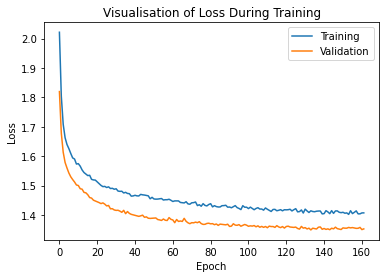

In [284]:
ax = plt.subplot()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Visualisation of Loss During Training')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Training', 'Validation'])
plt.show()

Visualising Accuracy during Training

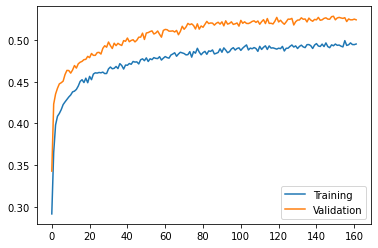

In [285]:
ax1 = plt.subplot()
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax.set_title('Visualisation of Accuracy During Training')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
plt.show()

**8.1.8 Evaluating the Model**

Scale test data as evaluate does not work on pipeline directly so just have to call the model within it

In [286]:
X_test_deep_scaled = deep_pipeline[0].transform(X_test)

Accuracy - Okay results to say there are 10 classes but not as good as the simple models, implying that the dataset may not be large enough to warrant a neural net

In [287]:
loss, acc = deep_pipeline[1].evaluate(X_test_deep_scaled, y_test_OH) # Get the model object from the pipeline and evaluate the model using test data

228/228 [==============================] - 0s 380us/step - loss: 1.3245 - accuracy: 0.5202


Classification Report - Okay results to say there are 10 classes but not as good as the simple models, implying that the dataset may not be large enough to warrant a neural net

In [288]:
y_prediction_classes = np.argmax(deep_pipeline[1].predict(X_test_deep_scaled), axis=1)
y_true_classes = np.argmax(y_test_OH, axis=1)
print(classification_report(y_true_classes, y_prediction_classes))

              precision    recall  f1-score   support

           0       0.48      0.77      0.59      2023
           1       0.00      0.00      0.00       336
           2       0.83      0.77      0.80       492
           3       0.00      0.00      0.00       247
           4       0.00      0.00      0.00       435
           5       0.47      0.64      0.54      1284
           6       0.00      0.00      0.00       244
           7       0.51      0.55      0.53       336
           8       0.58      0.54      0.56      1547
           9       0.00      0.00      0.00       332

    accuracy                           0.52      7276
   macro avg       0.29      0.33      0.30      7276
weighted avg       0.42      0.52      0.46      7276



Cross validation - Still better than just guessing the classification as that would statistically give an accuracy of 10%, therefore the model is better than that. However, the results of the neural network after cross-validation are worse than that of all the simple models, implying that the dataset is not large enough to warrant a neural network.

In [289]:
deep_model_wrapper = KerasClassifier(build_fn=build_model_final, batch_size = 94, epochs = 103, validation_split=0.2, verbose=0)

In [313]:
# Put model in Keras wrapper so it can be used in the cross validation

# Cross validation
cross_val_score_deep = cross_val_score(estimator=deep_model_wrapper, X=features_encoded, y=labels_encoded, cv=5, scoring='accuracy')

# Print average results
print(cross_val_score_deep)
print(f"Baseline: {cross_val_score_deep.mean()*100}% ({cross_val_score_deep.std()*100}%)")

[0.3062122  0.3161512  0.24659794 0.25292096 0.27890034]
Baseline: 28.015653024867333% (2.7727415621759155%)


Confusion Matrix - Lightest colours on the diagonal showing accurate predictions. However, again not as accurate as simple models

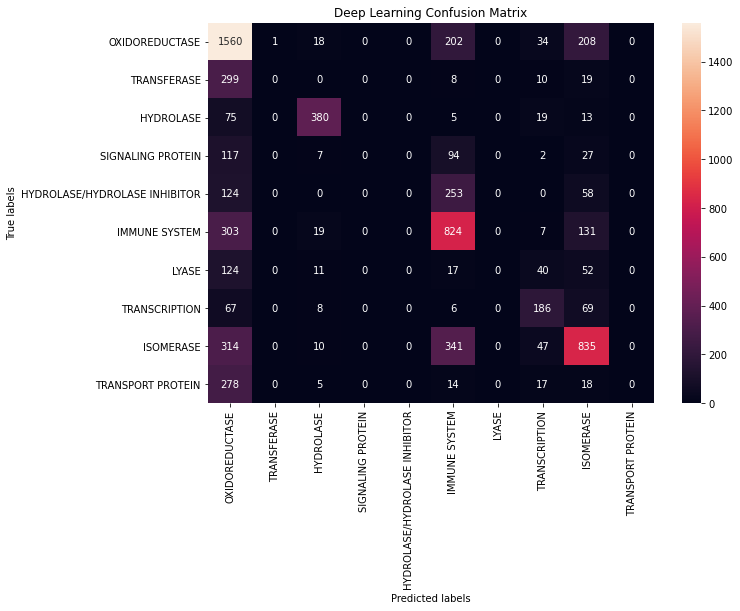

In [291]:
deep_cm = confusion_matrix(y_true_classes, y_prediction_classes)

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(deep_cm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Deep Learning Confusion Matrix')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**8.2 With PCA Data**

**8.2.1 Model Function for Randomized Search**

In [294]:
def build_model_pca(num_neurons_1, num_neurons_2):

    deep_model = Sequential()

    deep_model.add(layers.InputLayer(input_shape=(X_train_pca_reduced.shape[1],))) # Input shape is (number of features, 1) so model expected a number for each features for each row

    deep_model.add(layers.Dense(num_neurons_1, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(num_neurons_2, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(10, activation='softmax'))

    deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return deep_model

**8.2.2 Randomized Search for Hyperparameter Tuning**

In [295]:
def randomized_search_pca(data):
    
    # Parameter grid for batch size, epochs, optimizers and number of neurons
    param_grid = {'batch_size': sp_randint(10, 100), 'nb_epoch': sp_randint(10, 200), 'num_neurons_1': sp_randint(1, 64), 'num_neurons_2': sp_randint(1,64)} # Parameter grid
    
    model = KerasClassifier(build_fn=build_model_pca) # Model in Keras wrapper
    
    # Randomized Grid Search with model, parameter grid, 10 iterations, accuracy scorer and n_jobs = -1 (using all processesor)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring=make_scorer(accuracy_score))
    
    grid_results = grid.fit(data, y_train_OH, verbose=1) # Fitting data to model
    
    print(grid_results) # Printing out best results
    
    print(f'Best {grid_results.best_score_} using {grid_results.best_params_}')

In [296]:
randomized_search_pca(X_train_pca_reduced)

343/343 [==============================] - 0s 1ms/step - loss: 1.9546 - accuracy: 0.3246


571/571 [==============================] - 1s 889us/step - loss: 1.9661 - accuracy: 0.3143
RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A1B69E2550>,
                   n_iter=20,
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1C2FF3070>,
                                        'nb_epoch': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1B0606490>,
                                        'num_neurons_1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1DD89FD60>,
                                        'num_neurons_2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1D8D1DFA0>},
                   scoring=make_scorer(accuracy_score))
Best nan using {'batch_size': 51, 'nb_epoch': 17, 'num_neurons_1': 11, 'num_neurons_2': 54}


**8.2.3 Final Model Function with Tuned Hyperparameters**

In [298]:
def build_model_final_pca():
    
    deep_model = Sequential()

    deep_model.add(layers.InputLayer(input_shape=(X_train_pca_reduced.shape[1],))) # Input shape is (number of features, 1) so model expected a number for each features for each row

    deep_model.add(layers.Dense(11, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(54, activation='relu'))
    
    deep_model.add(layers.Dropout(0.1)) # Drop out 10% of neuron results to try and avoid overfitting

    deep_model.add(layers.Dense(10, activation='softmax'))

    deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return deep_model

**8.2.4 PCA Pipeline**

In [299]:
deep_pipeline_pca = Pipeline(steps=[
    ('model', build_model_final_pca())
])

stopper_pca = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Early Stopping object to stop when loss levels out at a minimum

**8.2.5 PCA History Callback**

In [300]:
history_pca = History() # For later callbacks of model results

**8.2.6 Fitting Model**

In [301]:
# Batch size = number of samples through the network before hyperparameters are tuned.

# Validation split for hyperparameter tuning was set at 20% of training data

deep_pipeline_pca.fit(X_train_pca_reduced, y_train_OH, model__epochs=17, model__batch_size=51, model__verbose=1, model__callbacks=[stopper_pca, history_pca], model__validation_split=0.2)

Epoch 1/17
457/457 [==============================] - 1s 2ms/step - loss: 1.9243 - accuracy: 0.3313 - val_loss: 1.7534 - val_accuracy: 0.3802
Epoch 2/17
457/457 [==============================] - 1s 2ms/step - loss: 1.7278 - accuracy: 0.3905 - val_loss: 1.6497 - val_accuracy: 0.4258
Epoch 3/17
457/457 [==============================] - 1s 2ms/step - loss: 1.6739 - accuracy: 0.4137 - val_loss: 1.6123 - val_accuracy: 0.4478
Epoch 4/17
457/457 [==============================] - 1s 3ms/step - loss: 1.6364 - accuracy: 0.4239 - val_loss: 1.5839 - val_accuracy: 0.4555
Epoch 5/17
457/457 [==============================] - 1s 3ms/step - loss: 1.6134 - accuracy: 0.4340 - val_loss: 1.5636 - val_accuracy: 0.4648
Epoch 6/17
457/457 [==============================] - 1s 3ms/step - loss: 1.5914 - accuracy: 0.4408 - val_loss: 1.5481 - val_accuracy: 0.4722
Epoch 7/17
457/457 [==============================] - 1s 3ms/step - loss: 1.5863 - accuracy: 0.4437 - val_loss: 1.5391 - val_accuracy: 0.4710
Epoch 

Pipeline(steps=[('model',
                 <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002A1D8B82490>)])

**8.2.7 Visualisation of Model Loss Results - Seems like overfitting has been avoided due to the dropout layers**

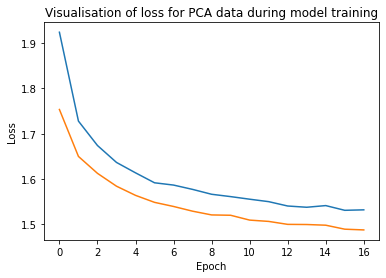

In [302]:
ax2 = plt.subplot()
ax2.plot(history_pca.history['loss'])
ax2.plot(history_pca.history['val_loss'])
ax2.set_title('Visualisation of loss for PCA data during model training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show()

**8.2.8 Visualisation of Model Accuracy Results - Seems like overfitting has been avoided due to the dropout layers**

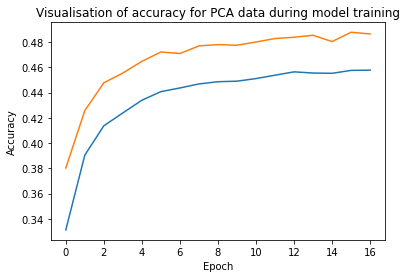

In [303]:
ax3 = plt.subplot()
ax3.plot(history_pca.history['accuracy'])
ax3.plot(history_pca.history['val_accuracy'])
ax3.set_title('Visualisation of accuracy for PCA data during model training')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
plt.show()

**8.2.9 Evaluating the PCA model**

Accuracy - Okay results again to say there are 10 classifications and very comparable to the other neural net. However, not as good as the simple machine learning models.

In [305]:
loss, acc = deep_pipeline_pca[0].evaluate(X_test_pca_reduced, y_test_OH)

228/228 [==============================] - 0s 1ms/step - loss: 1.4541 - accuracy: 0.4875


Classification Report - Okay results again to say there are 10 classifications and very comparable to the other neural net. However, not as good as the simple machine learning models.

In [309]:
predictions_pca = np.argmax(deep_pipeline_pca.predict(X_test_pca_reduced), axis=-1)
true_classes_pca = np.argmax(y_test_OH, axis=-1)
print(classification_report(true_classes_pca, predictions_pca))

              precision    recall  f1-score   support

           0       0.49      0.58      0.53      2023
           1       0.87      0.12      0.20       336
           2       0.77      0.77      0.77       492
           3       0.00      0.00      0.00       247
           4       0.92      0.17      0.28       435
           5       0.45      0.48      0.46      1284
           6       0.38      0.01      0.02       244
           7       0.54      0.46      0.50       336
           8       0.41      0.66      0.51      1547
           9       0.58      0.26      0.35       332

    accuracy                           0.49      7276
   macro avg       0.54      0.35      0.36      7276
weighted avg       0.52      0.49      0.46      7276



Cross validation - Cross-validation shows a big drop in accuracy from what was previously thought, with very comparable results to the other neural net model. Predictions are still better than random guesses of classifications, but are not as good as the simple machine learning models.

In [318]:
deep_model_wrapper_pca = KerasClassifier(build_fn=build_model_final_pca, batch_size = 51, epochs = 17, validation_split=0.2, verbose=0)

In [314]:
# Concat PCA dataframes for cross validation

features_encoded_pca = pd.concat([X_train_pca_reduced, X_test_pca_reduced])

In [320]:
cross_validation_score_pca = cross_val_score(estimator=deep_model_wrapper_pca, X=features_encoded_pca, y=labels_encoded, cv=5, scoring='accuracy')

print(cross_validation_score_pca)

print(f"Baseline: {cross_validation_score_pca.mean()*100}% ({cross_validation_score_pca.std()*100}%)")

[0.30648708 0.3161512  0.24701031 0.25237113 0.27862543]
Baseline: 28.01290312830017% (2.7791923423927467%)


Confusion Matrix - shows okay results with light colours on the diagonal. However, there are also a lot of light colours elsewhere signifying incorrect predictions

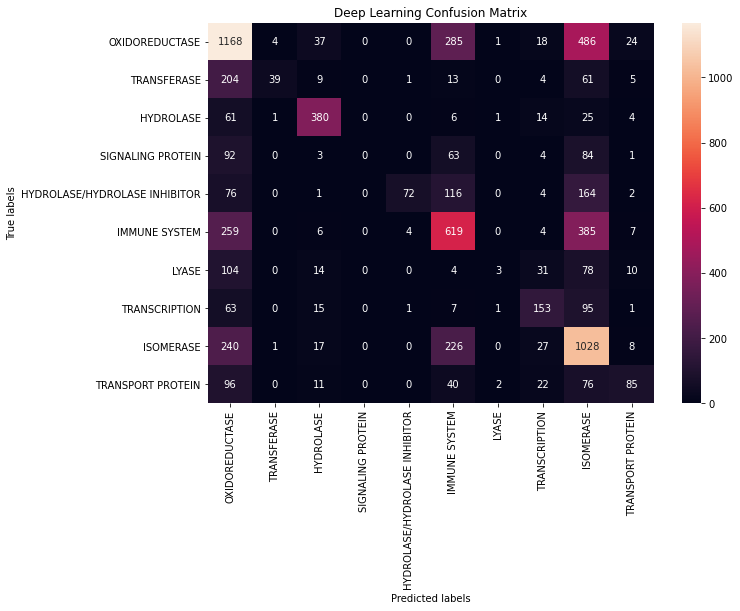

In [311]:
deep_cm_pca = confusion_matrix(true_classes_pca, predictions_pca)

plt.figure(figsize=(10,7))

ax = plt.subplot()

sns.heatmap(deep_cm_pca, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Deep Learning Confusion Matrix')

ax.yaxis.set_tick_params(rotation=360)

ax.xaxis.set_tick_params(rotation=90)

classes = new_df.classification.unique().tolist()

ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.show()

**9 Conclusion**

In conclusion the following were achieved in this project:
- Aggregate statistics and visualisations of the dataset were created to gain useful insights about the different features of the dataset in relation to the classifications
- Preprocessing was carried out to encode the categorical features of the dataset
- Various feature engineering techniques were used to improve the machine learning models. This included mutual information, KMeans clustering and principal component analysis
- Various simple machine learning models were then built (K Nearest Neighbour, Decision Tree, Random Forest and XGBoost) to predict a molecules structure, with the models being tuned to improve their accuracy. This was done for both the original dataset (w/ cluster labels) and the PCA dataset. These models were then evaluated using metrics such as accuracy, classification report, cross-validation and confusion matrices to see how accurate they were.
- Deep neural network models were then constructed for the original data and PCA data, using features such as dropout (to avoid overfitting) and earlystopping to improve the model. Randomized Grid Search was also used for both models to tune the batch size, epochs and number of neurons in each layers. Both models were then evaluated using the same metrics as the simple models.
- Furthermore, for all models pipelines were made to streamline the machine learning process.

The results of the project were:
- It was found that the most accurate simple machine learning model was the RandomForest with the original data model (RF_pipeline), achieving an accuracy of 86% from the test data. However, it was later found that the model was not as accurate as previously thought, achieving an accuracy of 65.64% from cross-validation, but this was true for all the models and so the RandomForest model was still the most accurate.
- Furthermore, it was found for all the tree models (DecisionTree, RandomForest and XGBoost) that the use of the PCA data significantly decreased accuracy when compared to use of the original data. This implied that the dimensionality reduction of PCA did not improve the tree models.
- It was found that the most accurate neural network model was the model using the original data (deep_pipeline) based on the test set. However, after cross-validation it was found that both the original data and PCA data models were both very comparable, indicating that PCA may not be worth it for this dataset.
- It was also found that the neural networks performed significantly worse that all the simple machine learning models, achieving an accuracy of 28% after cross validation, compared to 65.64% for the RandomForest model. This implies that the dataset may not be large or complex enough to warrant a neural network and that simple models will suffice.
- In conclusion, the RandomForest model with the original data (RF_pipeline) was found to be the best model for predicting molecular structure and therefore should be used for any future predictions.

**10 Further Work**

Further feature engineering could be done to improve the models by seeing which features could be combined to yield new relationships between variables. Furthermore, more tuning could be carried out on the models to improve their accuracy, improving future predictions.